In [136]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import utils as ut

In [137]:
import os
import glob
files = glob.glob('profiles/*.pkl')

out_train = {}
out_val = {}

for i, file in enumerate(files):
    with open(file, 'rb') as f:
        tmp = pickle.load(f)

        if i < 6:
            out_train = {**out_train, **tmp}

        else:
            out_val = {**out_val, **tmp}

nwindows = [10, 100, 1000]
X, y = ut.pickle_to_data(out_train, nwindow=nwindows)
X_val, y_val = ut.pickle_to_data(out_val, nwindow=nwindows)

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  ret

In [138]:
print(X.shape, y.shape)
print(X_val.shape, y_val.shape)

(441923, 143) (441923, 1)
(376628, 143) (376628, 1)


The following cell can be easily modified to fit any classifier that uses ``sklearn`` syntax. The parameters can be modified as well. 

In [139]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
X_train, X_test, y_train, y_test = train_test_split(X, le.fit_transform(y.values.reshape(-1)), test_size=0.66, random_state=42069)
clf = XGBClassifier(
    max_depth=5,             # Limit tree depth for better generalization
    min_child_weight=5,      # Minimum sum of instance weight (hessian) needed in a child
    reg_alpha=0,             # L1 regularization term on weights
    reg_lambda=1,            # L2 regularization term on weights
    subsample=0.6,           # Subsample ratio of the training instances
    colsample_bytree=0.6,    # Subsample ratio of columns when constructing each tree
    learning_rate=0.05,      # Lower learning rate for slower, more controlled training
    n_estimators=200         # Number of trees in the model
)
"""
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train)
clf.fit(X_train, y_train, sample_weight=class_weights[y_train])
"""

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
clf.fit(X_resampled, y_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [140]:
from sklearn.metrics import f1_score, accuracy_score

# how does the model fare?
train_score = f1_score(y_train, clf.predict(X_train), average='weighted')
test_score = f1_score(y_test, clf.predict(X_test), average='weighted')
val_score = f1_score(le.transform(y_val), clf.predict(X_val), average='weighted')

print(f'training f1 score is {train_score:.2f}')
print(f'testing f1 score is {test_score:.2f}')
print(f'val f1 score is {val_score:.2f}')

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


training f1 score is 0.98
testing f1 score is 0.98
val f1 score is 0.81


The training and testing score are too good to be true! Let's look at a few profiles that were used in the training set for understanding.

In [144]:
from matplotlib.colors import ListedColormap, BoundaryNorm
colors = ['tab:blue', 'tab:orange', 'tab:red']
cmap = ListedColormap(colors)
unique_labels = np.unique(y_train)
norm = BoundaryNorm(boundaries=np.arange(len(unique_labels) + 1) - 0.5, ncolors=len(unique_labels))


(0.0, 1494.5)

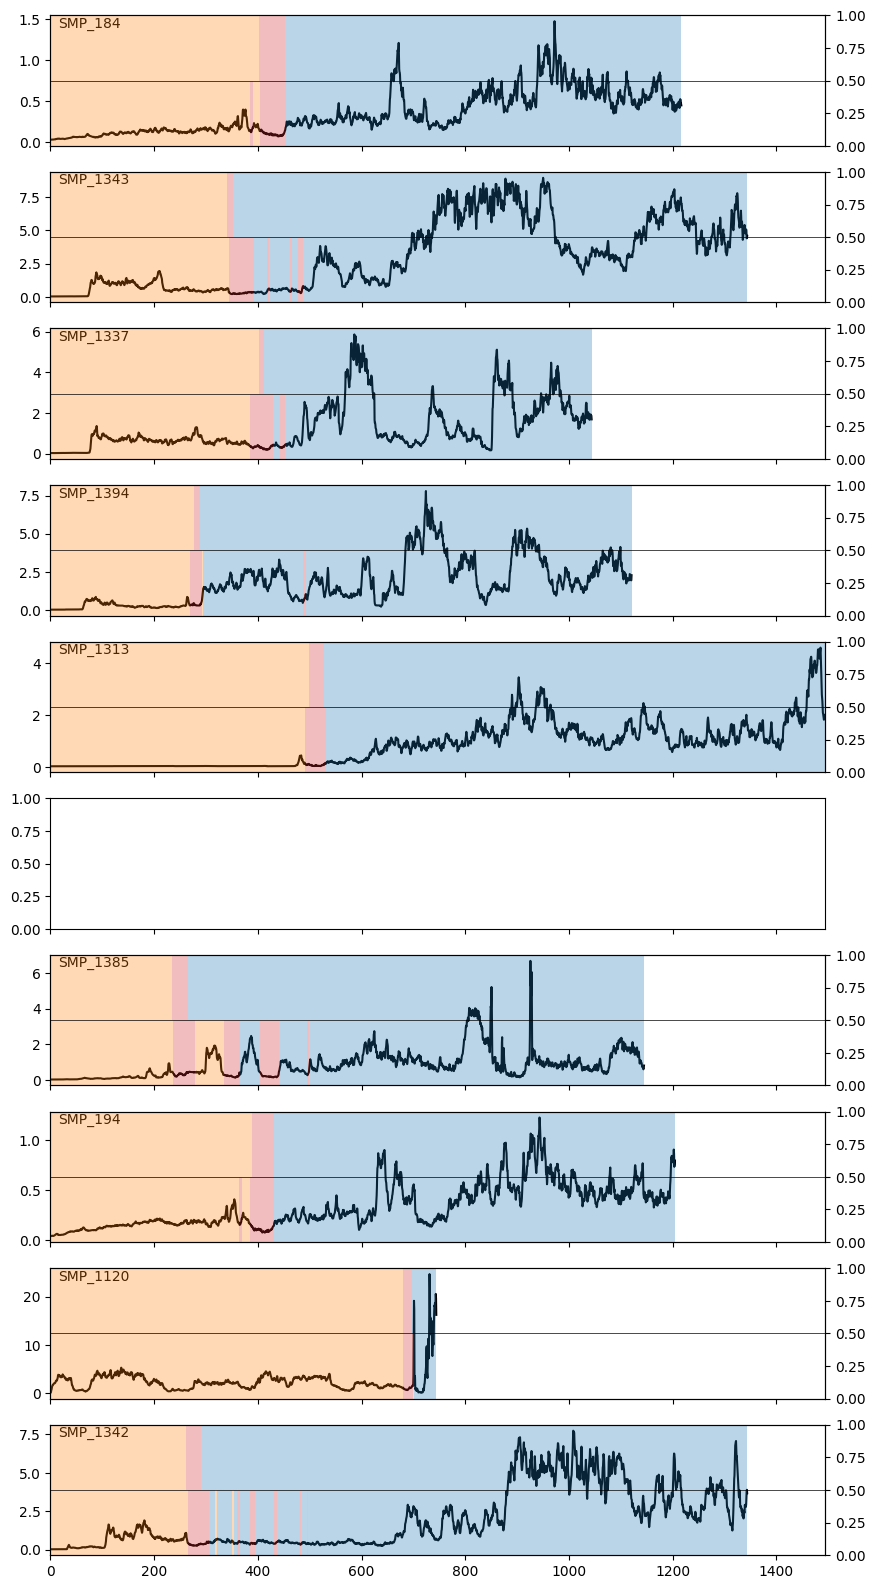

In [146]:
%matplotlib inline
nsamples = 10
keys = list(out_train.keys())
keys = np.random.choice(keys, nsamples)

fig, axs = plt.subplots(nsamples, 1, sharex='all', figsize=(10, 2 * nsamples))
for i, key in enumerate(keys):

    profile = out_train[key]

    if 'layer' not in profile.columns:
        continue

    xi, yi = ut.profile_to_df(profile)
    xi = ut.process_df_for_ensemble(xi, nwindow=nwindows)

    yi_prob = clf.predict_proba(xi)
    yi_hat = le.inverse_transform(yi_prob.argmax(axis=1))

    ax = axs[i]
    ax.text(0.01, 0.99, key, ha='left', va='top', transform=ax.transAxes)
    ax.plot(profile['distance'], profile['force_median'], c='k')

    ax2 = ax.twinx()
    ax2.pcolormesh(profile['distance'], [0.5, 1.0], le.transform(yi[:-1]).reshape(-1, 1).T, shading='flat', cmap=cmap, norm=norm, alpha=0.3)#, snap=True)
    ax2.pcolormesh(profile['distance'], [0.0, 0.5], le.transform(yi_hat[:-1]).reshape(-1, 1).T, shading='flat', cmap=cmap, norm=norm, alpha=0.3)#, snap=True)

    #for i, layer in enumerate(sorted(yi.unique())):
        #ax2.fill_between(profile['distance'], 0.5, 1.0, where=yi == layer, interpolate=True, alpha=0.3, fc=colors[i])
        #ax2.fill_between(profile['distance'], 0.0, 0.5, where=yi_hat == layer, interpolate=True, zorder=0, alpha=0.3, fc=colors[i])
        #ax2.pcolormesh(profile.index, [0.5, 1.0], np.tile(yi == layer, (2, 1)), shading='flat')

        #ax2.plot(profile['distance'], yi_prob[:, i], c=colors[i])
    
    ax2.axhline(0.5, c='k', lw=0.5)
    ax2.set_ylim(0, 1.0)
axs[-1].set_xlim(0, None)

What about validation profiles?

(0.0, 1281.5)

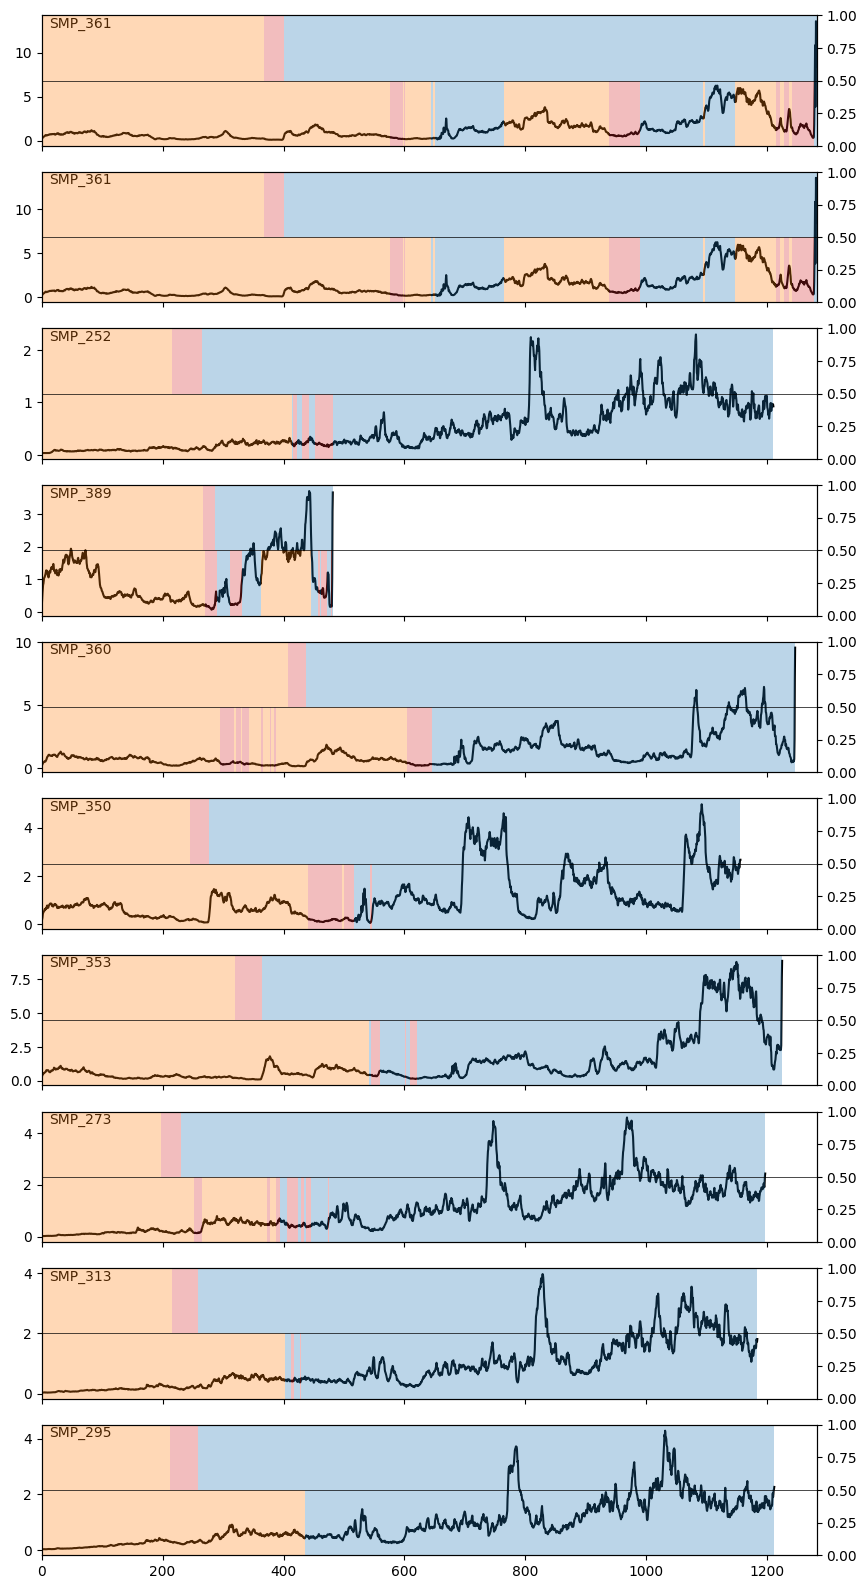

In [147]:
%matplotlib inline
nsamples = 10
keys = list(out_val.keys())
keys = np.random.choice(keys, nsamples)

fig, axs = plt.subplots(nsamples, 1, sharex='all', figsize=(10, 2 * nsamples))
for i, key in enumerate(keys):

    profile = out_val[key]

    if 'layer' not in profile.columns:
        continue

    xi, yi = ut.profile_to_df(profile)
    xi = ut.process_df_for_ensemble(xi, nwindow=nwindows)

    yi_prob = clf.predict_proba(xi)
    yi_hat = le.inverse_transform(yi_prob.argmax(axis=1))

    ax = axs[i]
    ax.text(0.01, 0.99, key, ha='left', va='top', transform=ax.transAxes)
    ax.plot(profile['distance'], profile['force_median'], c='k')

    ax2 = ax.twinx()
    ax2.pcolormesh(profile['distance'], [0.5, 1.0], le.transform(yi[:-1]).reshape(-1, 1).T, 
                   shading='flat', cmap=cmap, norm=norm, alpha=0.3)#, snap=True)
    ax2.pcolormesh(profile['distance'], [0.0, 0.5], le.transform(yi_hat[:-1]).reshape(-1, 1).T, 
                   shading='flat', cmap=cmap, norm=norm, alpha=0.3)#, snap=True)

    #for i, layer in enumerate(sorted(yi.unique())):
        #ax2.fill_between(profile['distance'], 0.5, 1.0, where=yi == layer, interpolate=True, alpha=0.3, fc=colors[i])
        #ax2.fill_between(profile['distance'], 0.0, 0.5, where=yi_hat == layer, interpolate=True, zorder=0, alpha=0.3, fc=colors[i])
        #ax2.pcolormesh(profile.index, [0.5, 1.0], np.tile(yi == layer, (2, 1)), shading='flat')

        #ax2.plot(profile['distance'], yi_prob[:, i], c=colors[i], lw=1)
    
    ax2.axhline(0.5, c='k', lw=0.5)
    ax2.set_ylim(0, 1.0)
axs[-1].set_xlim(0, None)

It lacks confidence in predicting weak layers in some areas, as well as predicting weak layers where it shouldn't. Computing confusion matrices helps us see clearer:

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


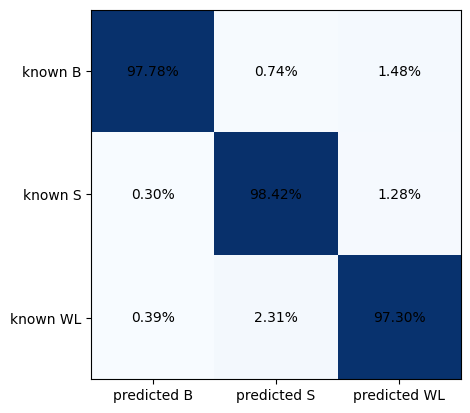

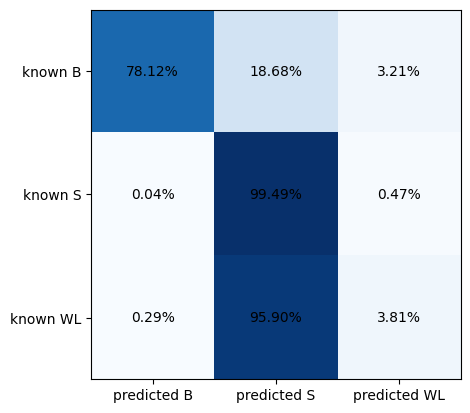

In [148]:
# the model picks the weak layer correctly, but it is probably uneable to generalize for now. let's look at the confusion matrix
from sklearn.metrics import confusion_matrix, f1_score

confmat = confusion_matrix(y_test, clf.predict(X_test), normalize='true')

fig, ax = plt.subplots()
ax.imshow(confmat, cmap='Blues')
ticks = np.arange(len(y.iloc[:, 0].unique()))
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_yticklabels([f'known {i}' for i in le.classes_])
ax.set_xticklabels([f'predicted {i}' for i in le.classes_])

for i in ticks:
    for j in ticks:
        ax.text(j, i, f'{100 * confmat[i, j]:.2f}%', ha='center', va='center')


confmat = confusion_matrix(le.transform(y_val), clf.predict(X_val), normalize='true')

fig, ax = plt.subplots()
ax.imshow(confmat, cmap='Blues')
ticks = np.arange(len(y.iloc[:, 0].unique()))
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_yticklabels([f'known {i}' for i in le.classes_])
ax.set_xticklabels([f'predicted {i}' for i in le.classes_])

for i in ticks:
    for j in ticks:
        ax.text(j, i, f'{100 * confmat[i, j]:.2f}%', ha='center', va='center')


#f1 = f1_score(y_val, clf.predict(X_val))
#f1